# data worth

In this notebook, we will use outputs from previous notebooks (in particular `pestpp-glm_part1.ipynb`) to undertake data worth assessments based on first-order second-moment (FOSM) techniques. "Worth" is framed here in the context of the extent to which the uncertainty surrounding a model prediction of management interest is reduced through data collection.  Given that these anayses can help target and optimize data acquisition strategies, this is a concept that really resonates with decision makers.

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size']=12
import flopy
import pyemu


flopy is installed in C:\Users\knowling\Dev\GW1876\activities_csiro\notebooks\flopy


In [2]:
m_d = "master_glm"

In [3]:
pst = pyemu.Pst(os.path.join(m_d,"freyberg_pp.pst"))
print(pst.npar_adj)
pst.write_par_summary_table(filename="none")

527


,type,transform,count,initial value,upper bound,lower bound,standard deviation
cn_hk6,cn_hk6,log,1,0,1,-1,0.5
cn_hk7,cn_hk7,log,1,0,1,-1,0.5
cn_hk8,cn_hk8,log,1,0,1,-1,0.5
cn_prsity6,cn_prsity6,log,1,0,1,-1,0.5
cn_prsity7,cn_prsity7,log,1,0,1,-1,0.5
cn_prsity8,cn_prsity8,log,1,0,1,-1,0.5
cn_rech4,cn_rech4,log,1,0,0.0413927,-0.0457575,0.0217875
cn_rech5,cn_rech5,log,1,0,0.0413927,-0.0457575,0.0217875
cn_ss6,cn_ss6,log,1,0,1,-1,0.5
cn_ss7,cn_ss7,log,1,0,1,-1,0.5


### first ingredient: parameter covariance matrix (representing prior uncertainty in this instance)

In [4]:
cov = pyemu.Cov.from_binary(os.path.join(m_d,"prior_cov.jcb")).to_dataframe()
cov = cov.loc[pst.adj_par_names,pst.adj_par_names]
cov = pyemu.Cov.from_dataframe(cov)

new binary format detected...


### second ingredient: jacobian matrix

In [5]:
jco = os.path.join(m_d,"freyberg_pp.jcb")

### the third ingredient--the (diagonal) noise covariance matrix--populated on-the-fly using weights when constructing the Schur object below...

In [6]:
sc = pyemu.Schur(jco=jco,parcov=cov)

## there we have it--all computations done and contained within `sc`.  We will only be required to access different parts of `sc` below...

## Parameter uncertainty

First let's inspect the (approx) posterior parameter covariance matrix and the reduction in parameter uncertainty through "data assimilation", before mapping to forecasts... (note that this matrix is ${\it not}$ forecast-specific)

In [23]:
sc.posterior_parameter.to_dataframe().sort_index(axis=1).iloc[100:105:,100:105]

,hk225,hk226,hk227,hk228,hk229
hk225,0.093333,0.019926,0.003091,0.001128,0.020917
hk226,0.019926,0.081598,0.019668,0.006277,0.029243
hk227,0.003091,0.019668,0.090720,0.030622,0.011145
hk228,0.001128,0.006277,0.030622,0.104660,0.001329
hk229,0.020917,0.029243,0.011145,0.001329,0.080951


We can see the posterior variance for each parameter along the diagonal. The off-diags are symmetric.

In [38]:
par_sum = sc.get_parameter_summary().sort_values("percent_reduction",ascending=False)
par_sum.head()

,percent_reduction,post_var,prior_var
flow_0001,87.379227,0.000173,0.001367
hk8_cn,82.586485,0.019348,0.111111
strk_0003,54.023848,0.204338,0.444444
welflux_000,52.465889,0.052816,0.111111
hk222,38.842096,0.067953,0.111111


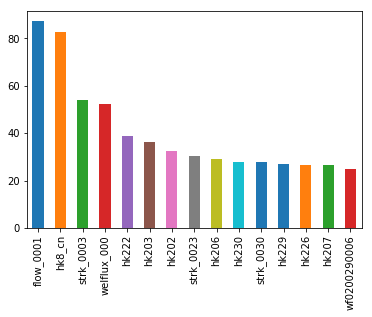

In [37]:
par_sum.loc[par_sum.index[:15],"percent_reduction"].plot(kind="bar")

What have we achieved by "notionally calibrating" our model to 13 head and 1 stream flow observations? Which parameters are informed? Will they matter for the forecast of interest? Which ones are un-informed?

## Forecast uncertainty

In [40]:
df = sc.get_forecast_summary()
df

,percent_reduction,post_var,prior_var
fa_hw_19791230,64.350080,4.599921e+04,1.290303e+05
fa_hw_19801229,21.344325,2.731591e+05,3.472847e+05
fa_tw_19791230,88.127961,2.043748e+04,1.721480e+05
fa_tw_19801229,41.327422,2.184906e+05,3.723897e+05
hds_00_013_002_000,98.824410,8.972545e-02,7.632373e+00
hds_00_013_002_001,98.009129,1.689069e-01,8.484073e+00
part_time,0.779595,1.258207e+07,1.268093e+07
part_status,NaN,0.000000e+00,0.000000e+00


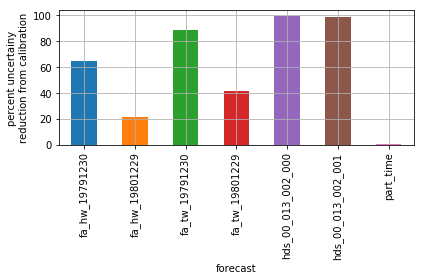

In [42]:
# make a pretty plot 
fig = plt.figure()
ax = plt.subplot(111)
ax = df.plot(kind='bar',ax=ax,grid=True)
ax.set_ylabel("percent uncertainy\nreduction from calibration")
ax.set_xlabel("forecast")
plt.tight_layout()

Surprise, surprise... Some forecasts benefit from calibration, some do not! 

### Before moving onto data worth, let's look at the contribution of different parameters to forecast uncertainty

Parameter contributions to uncertainty are quantified by "fixing" parameters (or parameter groups) and observing the uncertainty reduction as a result. This approach is of course subject to some sizable assumptions--related to parameter representativeness. But it can be very informative. Let's do by group.

In [51]:
par_contrib = sc.get_par_group_contribution()

In [52]:
par_contrib.head()

,fa_hw_19791230,fa_hw_19801229,fa_tw_19791230,fa_tw_19801229,hds_00_013_002_000,hds_00_013_002_001,part_status,part_time
base,45999.208695,273159.126193,20437.475638,218490.640452,0.089725,0.168907,0.0,1.258207e+07
cn_hk6,45670.367149,273002.628427,20337.569326,218435.182951,0.089376,0.168861,0.0,1.257663e+07
cn_hk7,45999.203632,273159.121981,20437.473127,218490.580039,0.089725,0.168907,0.0,1.258207e+07
cn_hk8,42643.883560,271632.419963,19337.356972,218274.514865,0.087930,0.165124,0.0,1.257893e+07
cn_prsity6,45999.208695,273159.126193,20437.475638,218490.640452,0.089725,0.168907,0.0,1.257428e+07


In [53]:
base = par_contrib.loc["base",:]
par_contrib = 100.0 * (base - par_contrib) / par_contrib

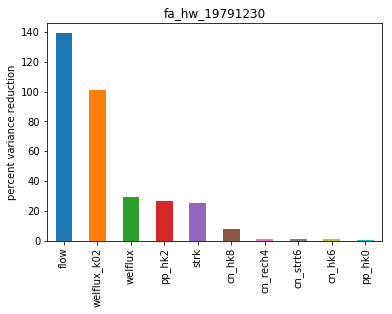

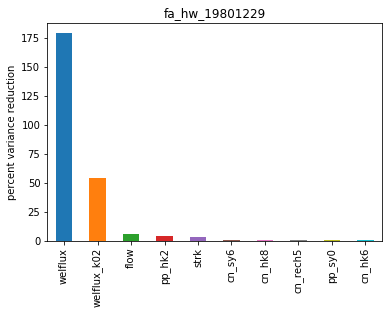

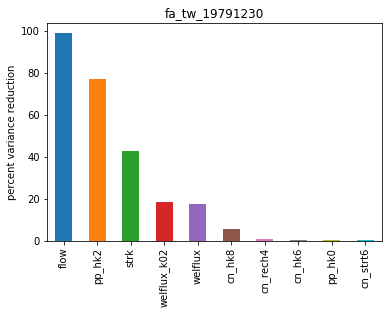

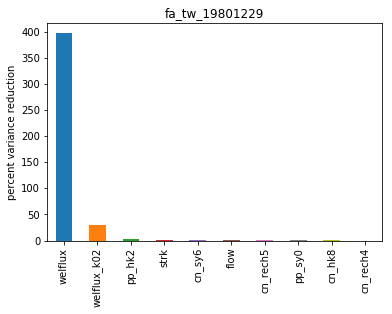

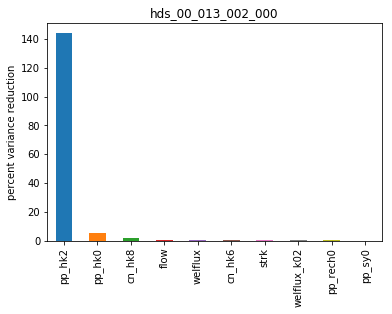

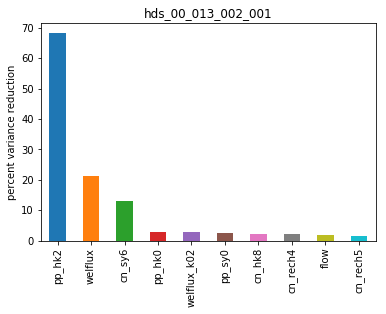

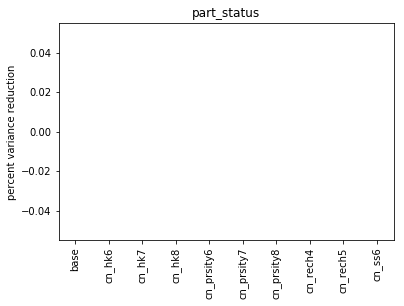

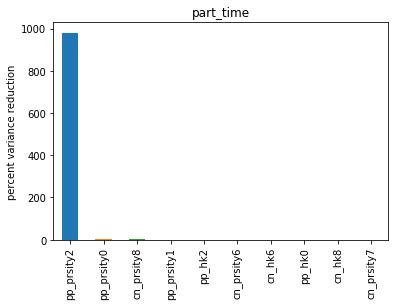

In [54]:
for forecast in par_contrib.columns:
    fore_df = par_contrib.loc[:,forecast].copy()
    fore_df.sort_values(inplace=True, ascending=False)
    ax = fore_df.iloc[:10].plot(kind="bar")
    ax.set_title(forecast)
    ax.set_ylabel("percent variance reduction")
    plt.show()

## Data worth

### what is the worth of ${\it existing}$ observations?

What is happening under the hood is that we are recalculating the Schur complement without some of the observations to see how the posterior forecast uncertainty increases (wrt a "base" condition in which we have all observation data available).

In [ ]:
dw_rm = sc.get_removed_obs_importance()
dw_rm.head()

Here the ``base`` row contains the results of the Schur complement calculation (in terms of forecast uncertainty variance) using all observations.  

In [58]:
# let's normalize to make more meaningful comparisons of data worth
base = dw_rm.loc["base",:]
dw_rm = 100 * (dw_rm  - base) / base
dw_rm.head()

,fa_hw_19791230,fa_hw_19801229,fa_tw_19791230,fa_tw_19801229,hds_00_013_002_000,hds_00_013_002_001,part_status,part_time
base,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
fo_39_19791230,4.012947,0.241318,1.690916,0.013422,0.074072,0.176625,NaN,0.000377
hds_00_002_009_000,0.476634,0.056937,0.031168,0.000093,0.097228,0.037509,NaN,0.000375
hds_00_002_015_000,0.048173,0.030031,0.025864,0.000261,0.018382,0.001039,NaN,0.000207
hds_00_003_008_000,0.289727,0.030338,0.000119,0.000024,0.598203,0.289228,NaN,0.010619


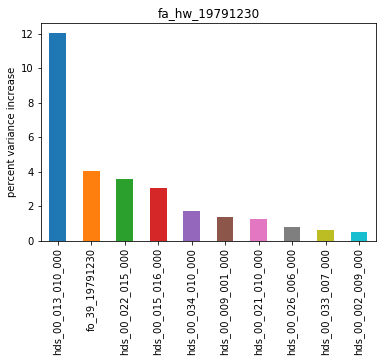

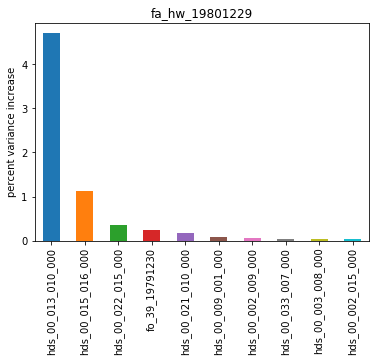

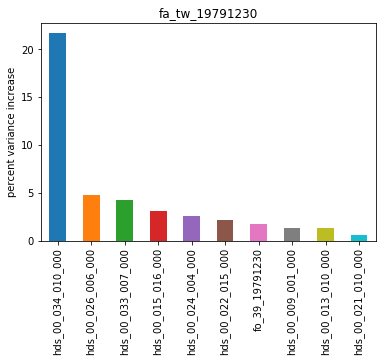

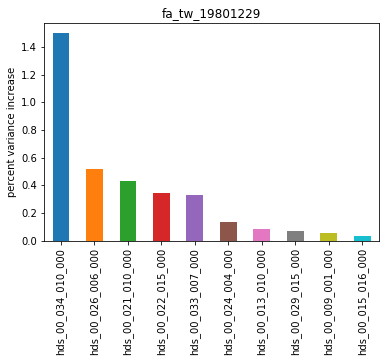

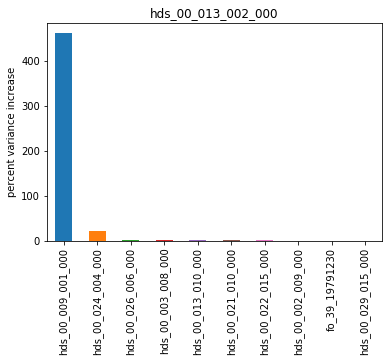

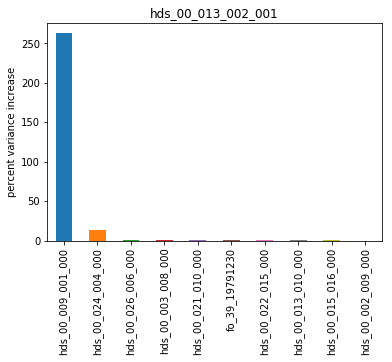

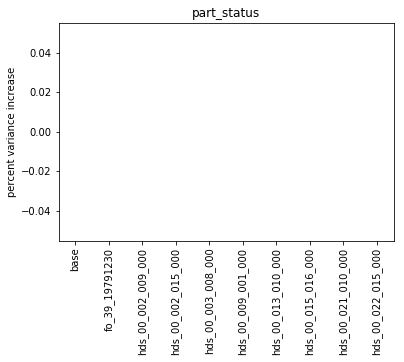

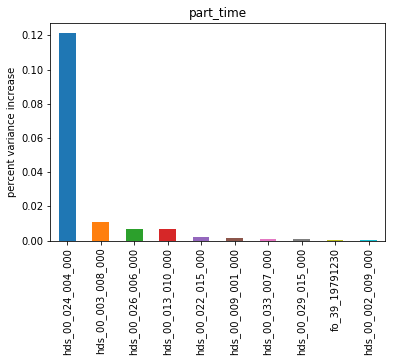

In [56]:
for forecast in dw_rm.columns:
    fore_df = dw_rm.loc[:,forecast].copy()
    fore_df.sort_values(inplace=True, ascending=False)
    ax = fore_df.iloc[:10].plot(kind="bar")
    ax.set_title(forecast)
    ax.set_ylabel("percent variance increase")
    plt.show()

There is also an option to calculate the worth of observations by taking a "base" condition of zero observation (i.e., a priori) and calculating the reduction in uncertainty through adding observations to the dataset. 

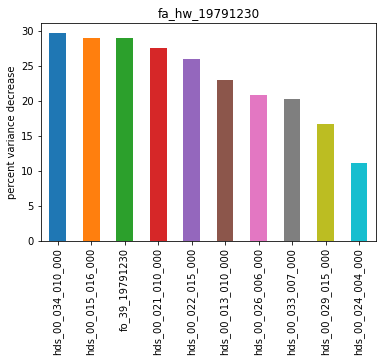

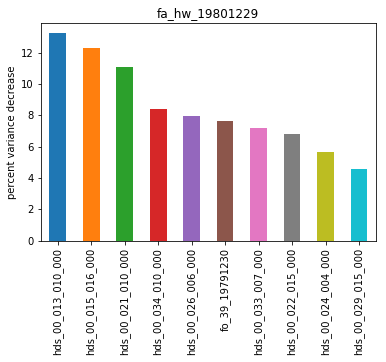

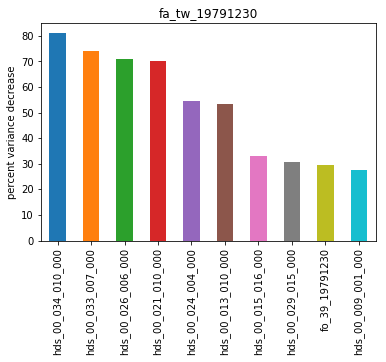

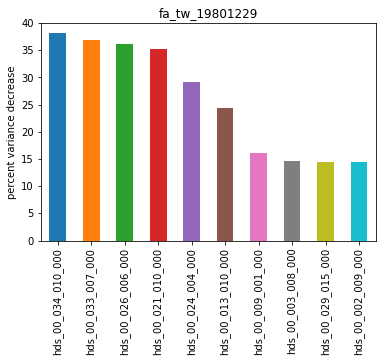

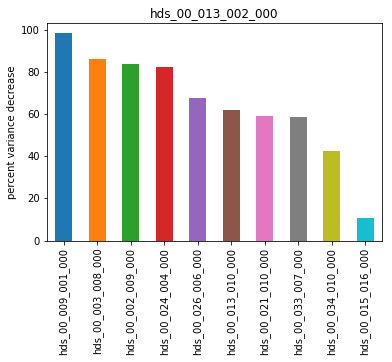

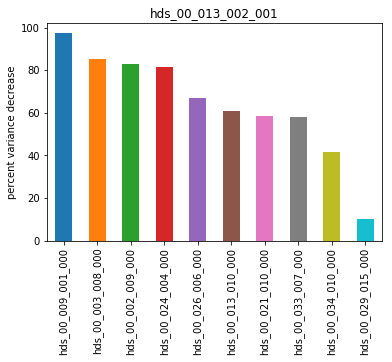

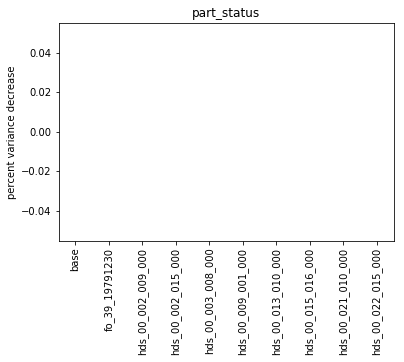

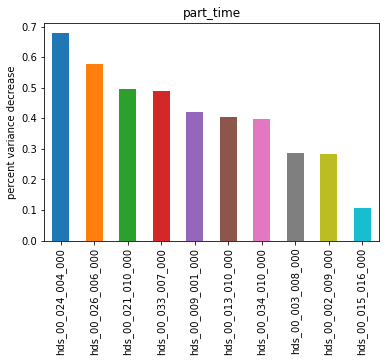

In [60]:
dw_ad = sc.get_added_obs_importance()
base = dw_ad.loc["base",:]
dw_ad = 100 * (base - dw_ad) / base
for forecast in dw_ad.columns:
    fore_df_ad = dw_ad.loc[:,forecast].copy()
    fore_df_ad.sort_values(inplace=True, ascending=False)
    ax = fore_df_ad.iloc[:10].plot(kind="bar")
    ax.set_title(forecast)
    ax.set_ylabel("percent variance decrease")
    plt.show()

Do these two approaches give the same answer? They shouldn't.. Why? Let's discuss..

### what is the worth of ${\it potential}$ observations? what data should we collect?

### Note: an important assumption underpinning the above is that the model is able to fit observations to a level that is commensurate with measurement noise... Are we comfortable with this assumption? We will discuss this more in `pestpp-glm_part2.ipynb`

In [33]:
# recall...
pst.observation_data.loc[pst.nnz_obs_names,:]

,obsnme,obsval,weight,obgnme,extra
obsnme,,,,,
fo_39_19791230,fo_39_19791230,11509.405235,0.01,calflux,NaN
hds_00_002_009_000,hds_00_002_009_000,38.548999,5.00,calhead,NaN
hds_00_002_015_000,hds_00_002_015_000,35.039936,5.00,calhead,NaN
hds_00_003_008_000,hds_00_003_008_000,39.295568,5.00,calhead,NaN
hds_00_009_001_000,hds_00_009_001_000,41.892383,5.00,calhead,NaN
hds_00_013_010_000,hds_00_013_010_000,35.223467,5.00,calhead,NaN
hds_00_015_016_000,hds_00_015_016_000,35.101131,5.00,calhead,NaN
hds_00_021_010_000,hds_00_021_010_000,35.159014,5.00,calhead,NaN
hds_00_022_015_000,hds_00_022_015_000,34.453687,5.00,calhead,NaN


## an extra: parameter identifiability